# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Calibrate
4. Calculate lattice vectors
5. **Fit lattice vectors**
6. Calculate strain
7. Visualize strain maps

# Notebook 5: Fit lattice vectors

In this step the initial lattice vector guesses are refined by performing a fit to the measured Bragg peaks.  We proceed as follows:

* Index the Bragg directions, using the initial $u,v$ guess and the braggvectormap maxima
* Fit the lattice vectors at each diffraction pattern.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from numpy.linalg import lstsq
from scipy.ndimage.morphology import binary_closing

from py4DSTEM.file.datastructure import RealSlice, PointList
from py4DSTEM.file.io import FileBrowser, read, append

from py4DSTEM.process.latticevectors import index_bragg_directions, fit_lattice_vectors, fit_lattice_vectors_all_DPs
from py4DSTEM.process.utils import get_maxima_2D

In [2]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    braggvectormap_shiftcorrected_ellipsecorrectedDiffractionSlice    
   2    braggvectormap_uncorrected          DiffractionSlice    
   3    probe                               DiffractionSlice    
   4    diffraction_shifts                  RealSlice           
   5    lattice_vectors                     PointList           
   6    braggpeaks                          PointListArray      
   7    braggpeaks_shifted_ellipticalcorrectedPointListArray      


In [3]:
# Load data

dc = browser.get_dataobject('datacube')
Bragg_peaks = browser.get_dataobject('braggpeaks_shifted_ellipticalcorrected')
lattice_vectors = browser.get_dataobject('lattice_vectors')
braggvectormap = browser.get_dataobject('braggvectormap_shiftcorrected_ellipsecorrected').data
browser.close()

### Index Bragg directions

In [4]:
# Get beta, the lattice vector matrix
# Note that for the initial pass

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap,2)),braggvectormap.shape)

ux = lattice_vectors.data['qx'][0]
uy = lattice_vectors.data['qy'][0]
vx = lattice_vectors.data['qx'][1]
vy = lattice_vectors.data['qy'][1]

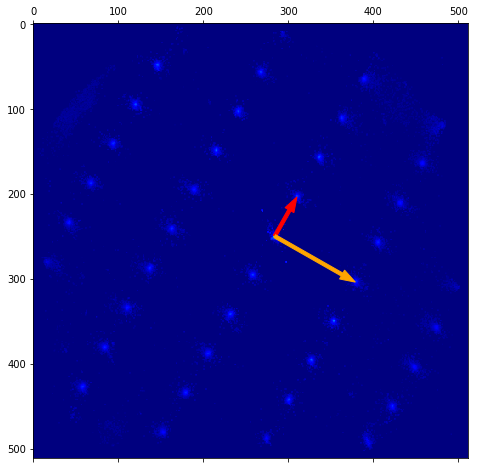

In [5]:
# Show deconvolition and lattice vectors

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**0.25,cmap='jet')
ax.arrow(y0,x0,uy,ux, color='red',width=4,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=4,length_includes_head=True)
plt.show()

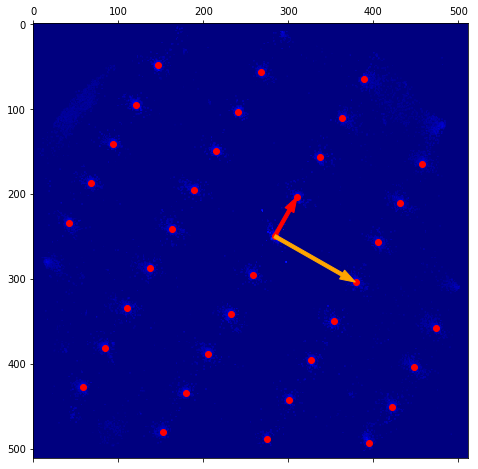

In [6]:
# Find Bragg vector map peak positions

sigma = 2
minSpacing = 40
minRelativeIntensity = 0.05
relativeToPeak = 1
maxNumPeaks = 40

power = 0.25

maxima_x,maxima_y,_ = get_maxima_2D(braggvectormap, sigma=sigma, minSpacing=minSpacing, minRelativeIntensity=minRelativeIntensity,
                                    relativeToPeak=relativeToPeak, maxNumPeaks=maxNumPeaks)

# Show
fig,ax=plt.subplots(figsize=(8,8))
ax.matshow(braggvectormap**power,cmap='jet')
ax.scatter(maxima_y,maxima_x,color='r')
ax.arrow(y0,x0,uy,ux, color='red',width=4,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=4,length_includes_head=True)
plt.show()

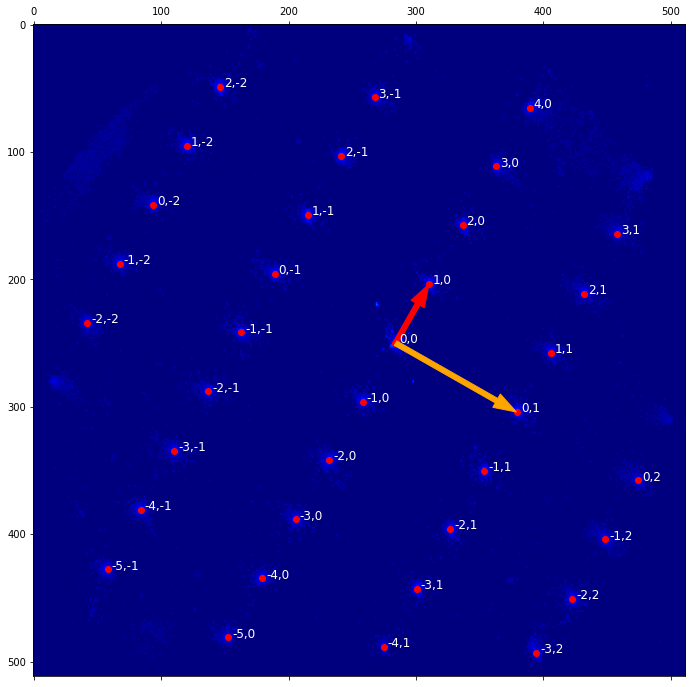

In [7]:
# Calculate indices

textoffset=3

# Get indices
h,k,bragg_directions = index_bragg_directions(x0,y0,ux,uy,vx,vy,maxima_x,maxima_y)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap**.25,cmap='jet')
ax.scatter(bragg_directions.data['qy'],bragg_directions.data['qx'],color='r')
ax.arrow(y0,x0,uy,ux, color='red',width=4,length_includes_head=True)
ax.arrow(y0,x0,vy,vx, color='orange',width=4,length_includes_head=True)
for i in range(bragg_directions.length):
    ax.text(bragg_directions.data['qy'][i]+textoffset,bragg_directions.data['qx'][i],
            '{},{}'.format(bragg_directions.data['h'][i],bragg_directions.data['k'][i]),
            color='w',size=12)
plt.show()

### Fit lattice vectors

In [8]:
# Perform fit

maxPeakSpacing = 20
minNumPeaks = 6
x0,y0 = np.unravel_index(np.argmax(braggvectormap),braggvectormap.shape)

uv_map = fit_lattice_vectors_all_DPs(Bragg_peaks, bragg_directions, x0, y0, maxPeakSpacing, minNumPeaks)

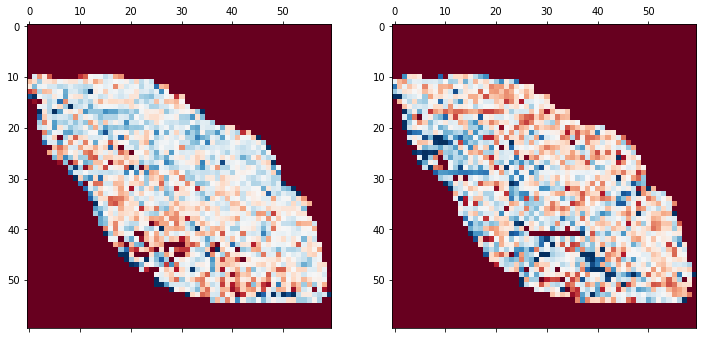

In [9]:
# Plot lattice vector lengths

n_stds = 2

u_lengths = np.sqrt(uv_map.data['ux']**2 + uv_map.data['uy']**2)
v_lengths = np.sqrt(uv_map.data['vx']**2 + uv_map.data['vy']**2)
u_length_ave, u_length_std = np.average(u_lengths[uv_map.data['mask'].astype(bool)]), np.std(u_lengths[uv_map.data['mask'].astype(bool)])
v_length_ave, v_length_std = np.average(v_lengths[uv_map.data['mask'].astype(bool)]), np.std(v_lengths[uv_map.data['mask'].astype(bool)])

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,12))
ax1.matshow(u_lengths, vmin=u_length_ave-n_stds*u_length_std, vmax=u_length_ave+n_stds*u_length_std, cmap="RdBu")
ax2.matshow(v_lengths, vmin=v_length_ave-n_stds*v_length_std, vmax=v_length_ave+n_stds*v_length_std, cmap="RdBu")
plt.show()

### Save lattice vector maps

In [10]:
# Append to processing file

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
append(uv_map, fp)

Opening file /home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5...
Done.
